# Problem Statement:
Here we want to classidy the emotion of a person's face, and we have five classes to classify. Those classes are surprise, anger, disgust, happy and sad.

# Importing Libraries:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers
import tensorflow as tf
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K

In [3]:
! unzip /content/'Face Emotions.zip'

Archive:  /content/Face Emotions.zip
   creating: Face Emotions/
  inflating: Face Emotions/FacialExpression_weights.hdf5  
  inflating: Face Emotions/emotion.csv  
  inflating: Face Emotions/Emotion-model.json  


# Loading & Examining The Data:

In [4]:
df = pd.read_csv('/content/Face Emotions/emotion.csv')

In [5]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [6]:
df['pixels'] = df[' pixels']

In [7]:
# Converting The Pictures From Strings To Numpy Arrays:
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

df['pixels'] = df['pixels'].apply(lambda x: string2array(x))

In [8]:
# checking for the presence of null values in the data frame
df.isnull().sum()

emotion    0
 pixels    0
pixels     0
dtype: int64

In [9]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

# Visualizing The Data:


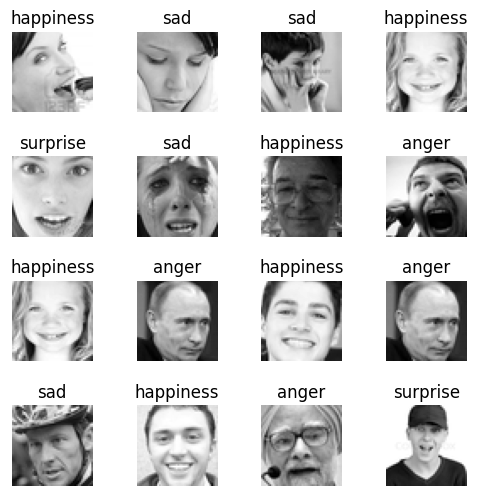

In [10]:
m,n,_ = df.pixels[1].shape

fig, ax = plt.subplots(4,4,figsize=(5,5))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(ax.flat):
    rand = np.random.randint(m)
    
    ax.imshow(df.pixels[rand].reshape(48,48,1), cmap='gray')
    ax.set_title(label_to_text[df.emotion[rand]])
    ax.set_axis_off()

<Axes: ylabel='emotion'>

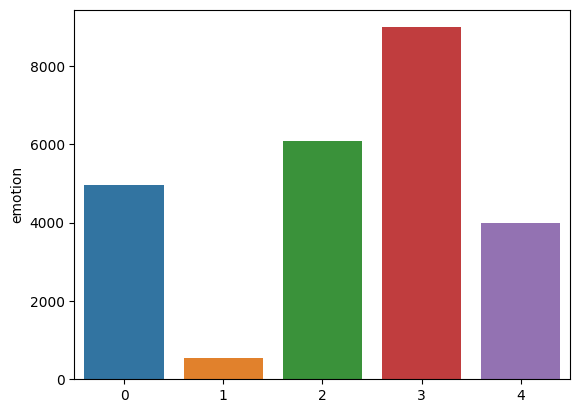

In [11]:
sns.barplot(x = df.emotion.value_counts().index, y= df.emotion.value_counts())

### Note the class imbalances.

# Data Augmentation:

In [12]:
# split the dataframe to features and labels
X = df.pixels
X = np.stack(X, axis=0)
y = pd.get_dummies(df.emotion)

In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
# spliting the dataframe in to train,test and validation data frames
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size = 0.5, shuffle = True)

In [15]:
# image pre-processing
X_train = X_train/255
X_val   = X_val /255
X_test  = X_test/255

In [16]:
# Data Augmentation:
train_gen = ImageDataGenerator(rotation_range=15,
                               zoom_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               horizontal_flip=True,
                               shear_range=0.2
                              )

# Building The Model:

In [17]:
def res_block(X, filter, stage):

  # Convolutional_block
    X_copy = X

    f1 , f2, f3 = filter

  # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = MaxPool2D((2,2))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
    X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
    X_copy = MaxPool2D((2,2))(X_copy)
    X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

  # Identity Block 1
    X_copy = X


  # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

  # Identity Block 2
    X_copy = X


  # Main Path
    X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X) 

    X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [18]:
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [19]:
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [32]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_accuracy', mode = 'min', verbose = 1, patience = 50)

# Training The Model:

In [33]:
history = model_emotion.fit(train_gen.flow(X_train, y_train),
                            validation_data=(X_val, y_val),
                            batch_size=32,
                            epochs = 100,
                            callbacks= earlystopping
                           )

Epoch 1/100
691/691 [==============================] - 20s 28ms/step - loss: 0.6135 - accuracy: 0.7630 - val_loss: 0.8262 - val_accuracy: 0.6963
Epoch 2/100
691/691 [==============================] - 21s 30ms/step - loss: 0.6038 - accuracy: 0.7691 - val_loss: 0.7130 - val_accuracy: 0.7345
Epoch 3/100
691/691 [==============================] - 20s 29ms/step - loss: 0.6079 - accuracy: 0.7665 - val_loss: 0.7615 - val_accuracy: 0.7077
Epoch 4/100
691/691 [==============================] - 19s 28ms/step - loss: 0.5961 - accuracy: 0.7708 - val_loss: 0.7593 - val_accuracy: 0.7166
Epoch 5/100
691/691 [==============================] - 22s 32ms/step - loss: 0.6023 - accuracy: 0.7681 - val_loss: 0.8774 - val_accuracy: 0.6604
Epoch 6/100
691/691 [==============================] - 20s 29ms/step - loss: 0.5961 - accuracy: 0.7698 - val_loss: 0.7169 - val_accuracy: 0.7239
Epoch 7/100
691/691 [==============================] - 19s 28ms/step - loss: 0.5935 - accuracy: 0.7689 - val_loss: 0.7377 - val_ac

# Evaluating The Model:

In [34]:
score = model_emotion.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 0s 8ms/step - loss: 0.6484 - accuracy: 0.7844
Test Accuracy: 0.7843775153160095


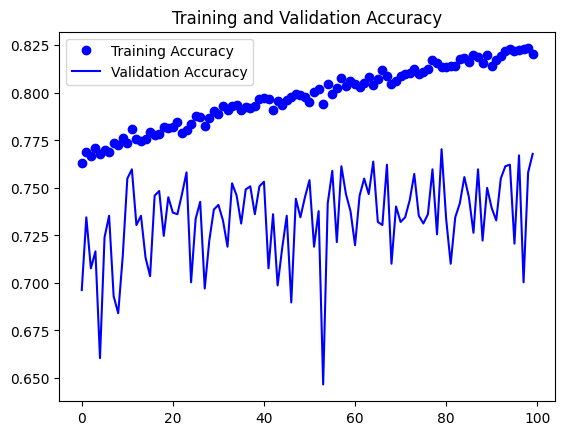

In [35]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [36]:
predicted_classes = np.argmax(model_emotion.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

39/39 [==============================] - 1s 4ms/step


<Axes: >

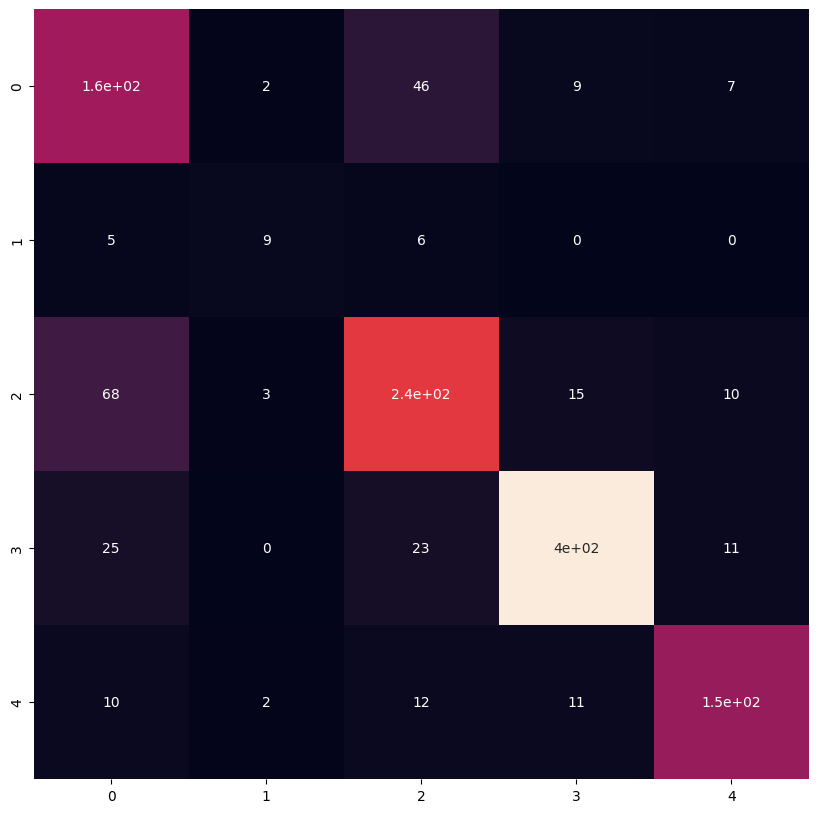

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

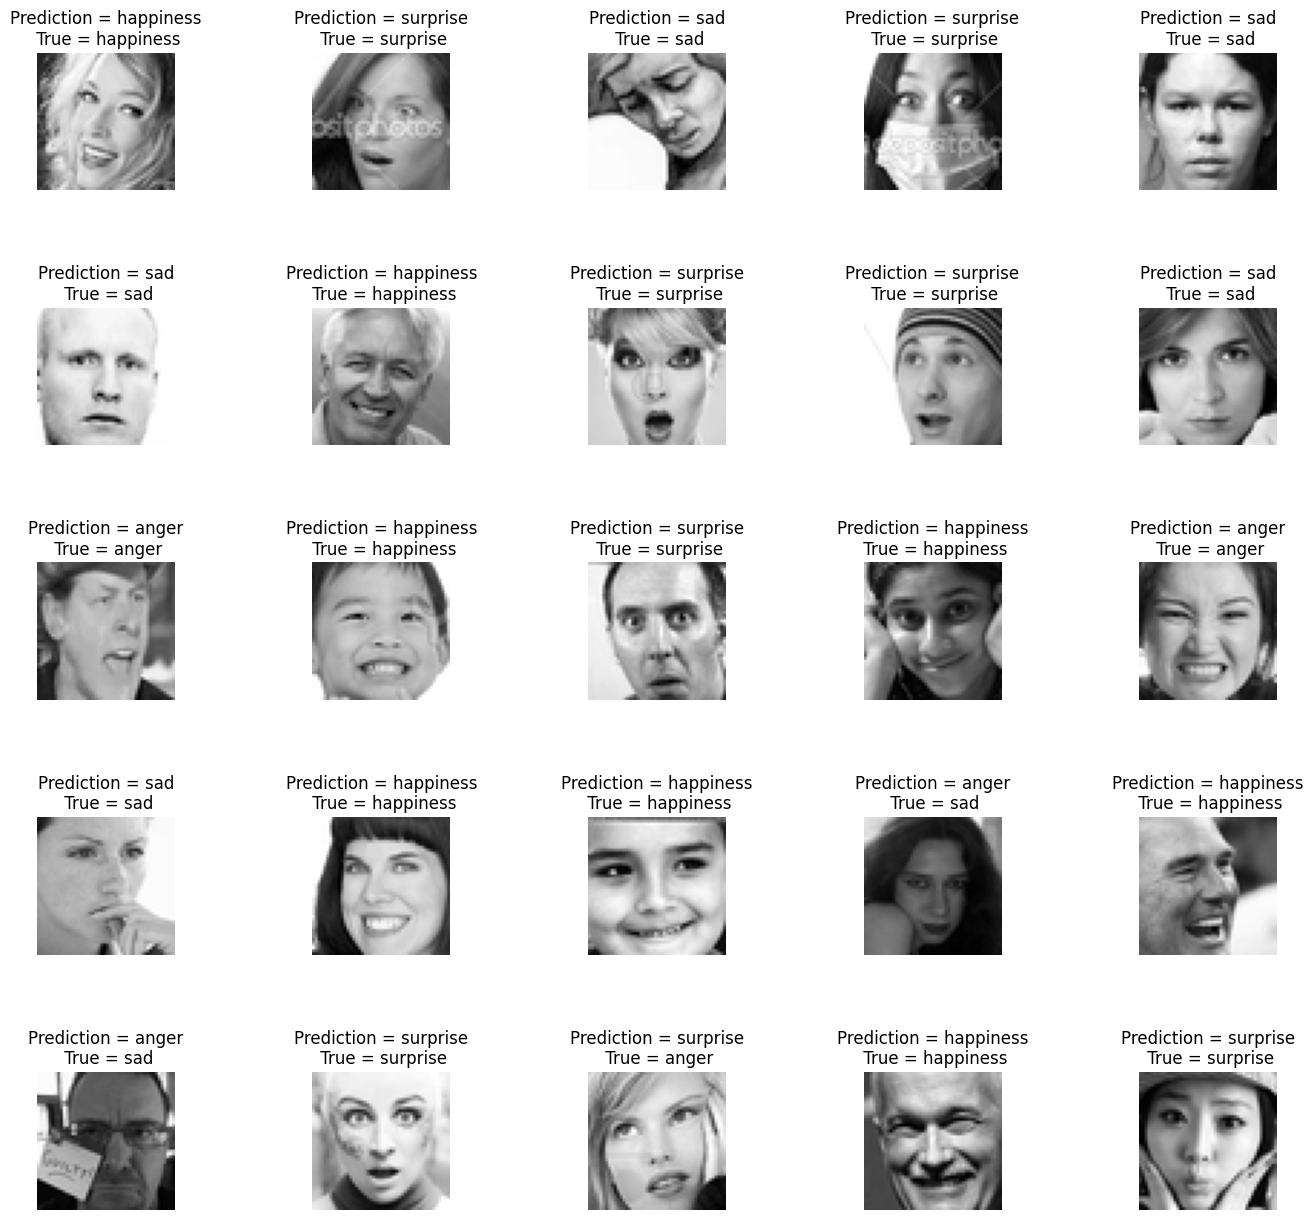

In [38]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (16, 16))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(48,48), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1) 

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.60      0.72      0.65       226
           1       0.56      0.45      0.50        20
           2       0.73      0.71      0.72       332
           3       0.92      0.87      0.90       464
           4       0.84      0.81      0.83       187

    accuracy                           0.78      1229
   macro avg       0.73      0.71      0.72      1229
weighted avg       0.79      0.78      0.79      1229

